# 🚀 FinSentiment 2.0: Analytics Avanzados y Datos de Mercado

Versión mejorada con integración de **Precios de Acciones (yfinance)**, **Fechas Reales** y **Deep Dive de Texto**.

### Nuevas Características:
1. **Comparativa de Mercado**: Gráfico Precio vs Sentimiento.
2. **Real Dates**: Extracción de fecha real del reporte (no simulada).
3. **Text Mining**: Top 5 oraciones positivas/negativas y palabras clave.
4. **Scoreboard**: Tabla detallada de métricas.

In [10]:
# @title 1. Instalación de Dependencias
!pip install sec-edgar-downloader transformers torch pandas numpy matplotlib seaborn beautifulsoup4 yfinance

In [13]:
# @title 2. Definición del Motor (Core Engine)

import os
import re
import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from collections import Counter
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from sec_edgar_downloader import Downloader
from transformers import BertTokenizer, BertForSequenceClassification

# Configurar estilos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]

# --- MÓDULO 1: INGESTA (CON EXTRACCIÓN DE FECHAS) ---
class SECLoader:
    def __init__(self, data_dir="data", email="research@example.com", company="Personal Research"):
        self.data_dir = data_dir
        os.makedirs(os.path.join(data_dir, "raw"), exist_ok=True)
        os.makedirs(os.path.join(data_dir, "processed"), exist_ok=True)
        self.downloader = Downloader(company, email, os.path.join(data_dir, "raw"))

    def download_filings(self, ticker: str, amount: int = 2):
        path = os.path.join(self.data_dir, "raw", "sec-edgar-filings", ticker)
        if os.path.exists(path):
             print(f"[>] Archivos para {ticker} ya descargados.")
             return

        print(f"[>] Descargando {amount} reportes para {ticker}...")
        try:
            self.downloader.get("10-K", ticker, limit=amount)
            print("[+] Descarga completa.")
        except Exception as e:
            print(f"[!] Error en descarga: {e}")

    def extract_date(self, content: str) -> str:
        # Busca la fecha de reporte en el encabezado SGML/HTML
        patterns = [
            r'FILED AS OF DATE:\s+(\d{8})',
            r'CONFORMED PERIOD OF REPORT:\s+(\d{8})'
        ]
        for p in patterns:
            match = re.search(p, content)
            if match:
                date_str = match.group(1)
                return f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}" # YYYY-MM-DD
        return None

    def extract_mda(self, html_content: str) -> str:
        soup = BeautifulSoup(html_content, 'html.parser')
        text = soup.get_text(separator='\n')

        # Lógica Robusta (Fallback)
        patterns = [r'Item\s+7\.\s+Management', r"Management's\s+Discussion", r'Item\s+7\.']
        start_idx = -1
        for p in patterns:
            match = re.search(p, text, re.IGNORECASE)
            if match: start_idx = match.start(); break

        if start_idx == -1: return text[:50000] # Fallback agresivo
        return text[start_idx:start_idx+20000]

    def process_filings(self, ticker: str):
        raw_path = os.path.join(self.data_dir, "raw", "sec-edgar-filings", ticker)
        processed_data = []

        for root, _, files in os.walk(raw_path):
            for file in files:
                if file.lower().endswith(".txt") and "primary" not in file:
                    try:
                        with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
                            content = f.read()

                        mda = self.extract_mda(content)
                        date = self.extract_date(content)

                        if len(mda) > 500:
                            processed_data.append({
                                'text': mda,
                                'date': date,
                                'accession': os.path.basename(os.path.dirname(os.path.join(root, file)))
                            })
                    except: pass
        return processed_data

# --- MÓDULO 2: PREPROCESAMIENTO ---
class TextPreprocessor:
    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text)
        return "".join(ch for ch in text if ch.isprintable()).strip()

    def split_sentences(self, text):
        # Split básico pero efectivo
        sentences = re.split(r'(?<=[.!?])\s+(?=[A-Z])', text)
        return [s.strip() for s in sentences if len(s.split()) >= 5]

# --- MÓDULO 3: MODELO FINBERT ---
class FinBertModel:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[*] Cargando FinBERT en {self.device}...")
        self.tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
        self.model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert").to(self.device)
        self.labels = {0: 'positive', 1: 'negative', 2: 'neutral'}

    def predict(self, sentences):
        if not sentences: return pd.DataFrame()
        # Batch processing automático
        batch_size = 32
        results = []

        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

            for j, s in enumerate(batch):
                idx = np.argmax(probs[j])
                results.append({
                    "sentence": s,
                    "sentiment": self.labels[idx],
                    "score": probs[j][idx], # Confidence
                    "pos_val": probs[j][0],
                    "neg_val": probs[j][1],
                    "neu_val": probs[j][2]
                })
        return pd.DataFrame(results)

# --- MÓDULO 4: MARKET DATA (YFINANCE) ---
def get_market_data(ticker, start_date, end_date):
    print(f"[*] Descargando precios de {ticker} ({start_date} a {end_date})...")
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return df['Close']

# --- MÓDULO 5: ANALYTICS & VISUALIZACIÓN ---
def analyze_keywords(sentences, top_k=10):
    # Stopwords básicas
    stopwords = set(['the', 'and', 'of', 'to', 'in', 'a', 'that', 'for', 'is', 'on', 'with', 'as', 'our', 'we', 'are', 'by', 'it', 'from', 'an', 'be', 'files', 'company'])
    words = []
    for s in sentences:
        words.extend([w.lower() for w in re.findall(r'\b[a-zA-Z]{3,}\b', s) if w.lower() not in stopwords])
    return Counter(words).most_common(top_k)

def show_dashboard(ticker, results_df, market_data=None):
    # 1. Tabla de Scores
    print("\n" + "="*60)
    print(f" SCOREBOARD: {ticker}")
    print("="*60)
    summary = results_df.groupby('date')[['pos_val', 'neg_val']].mean()
    summary['net_score'] = summary['pos_val'] - summary['neg_val']
    display(summary.style.background_gradient(cmap='RdYlGn', subset=['net_score']))

    # 2. Visualización Precio vs Sentimiento
    if market_data is not None:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        color = '#2E86AB'
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Sentiment Score', color=color, fontweight='bold')
        ax1.plot(pd.to_datetime(summary.index), summary['net_score'], 'o-', color=color, linewidth=2, markersize=8)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.axhline(0, color='gray', alpha=0.3)

        # Eje secundario para Precio
        ax2 = ax1.twinx()
        color = '#F24236'
        ax2.set_ylabel(f'Precio {ticker} ($)', color=color, fontweight='bold')
        ax2.plot(market_data.index, market_data, color=color, alpha=0.6, linewidth=1.5)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f"{ticker}: Correlación Precio vs Sentimiento MD&A", fontsize=14)
        plt.show()

    # 3. Top Sentences & Keywords (del último reporte)
    latest_date = results_df['date'].max()
    latest_df = results_df[results_df['date'] == latest_date]

    print(f"\n\n>>> DEEP DIVE (Reporte {latest_date})")

    # Top Positivas
    print("\n[TOP 5 POSITIVAS]")
    top_pos = latest_df.nlargest(5, 'pos_val')
    for _, r in top_pos.iterrows():
        print(f"(+) {r['pos_val']:.2f}: {r['sentence'][:150]}...")

    # Top Negativas
    print("\n[TOP 5 NEGATIVAS]")
    top_neg = latest_df.nlargest(5, 'neg_val')
    for _, r in top_neg.iterrows():
        print(f"(-) {r['neg_val']:.2f}: {r['sentence'][:150]}...")

    # Keywords
    pos_text = latest_df[latest_df['sentiment']=='positive']['sentence']
    neg_text = latest_df[latest_df['sentiment']=='negative']['sentence']

    print("\n[KEYWORDS FRECUENTES]")
    print(f"Positivas: {[k for k,v in analyze_keywords(pos_text)]}")
    print(f"Negativas: {[k for k,v in analyze_keywords(neg_text)]}")

[>] Archivos para META ya descargados.
[*] Cargando FinBERT en cpu...
Processing report from 2025-01-30...
Processing report from 2020-01-30...
Processing report from 2023-02-02...
Processing report from 2022-02-03...
Processing report from 2021-01-28...
Processing report from 2024-02-02...
[*] Descargando precios de META (2019-12-31 00:00:00 a 2025-03-01 00:00:00)...

 SCOREBOARD: META


/tmp/ipython-input-2656060886.py:141: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


,pos_val,neg_val,net_score
date,,,
2020-01-30,0.089748,0.169325,-0.079577
2021-01-28,0.081939,0.174577,-0.092637
2022-02-03,0.084212,0.162809,-0.078597
2023-02-02,0.097225,0.171587,-0.074362
2024-02-02,0.099181,0.158433,-0.059252
2025-01-30,0.099297,0.136844,-0.037547


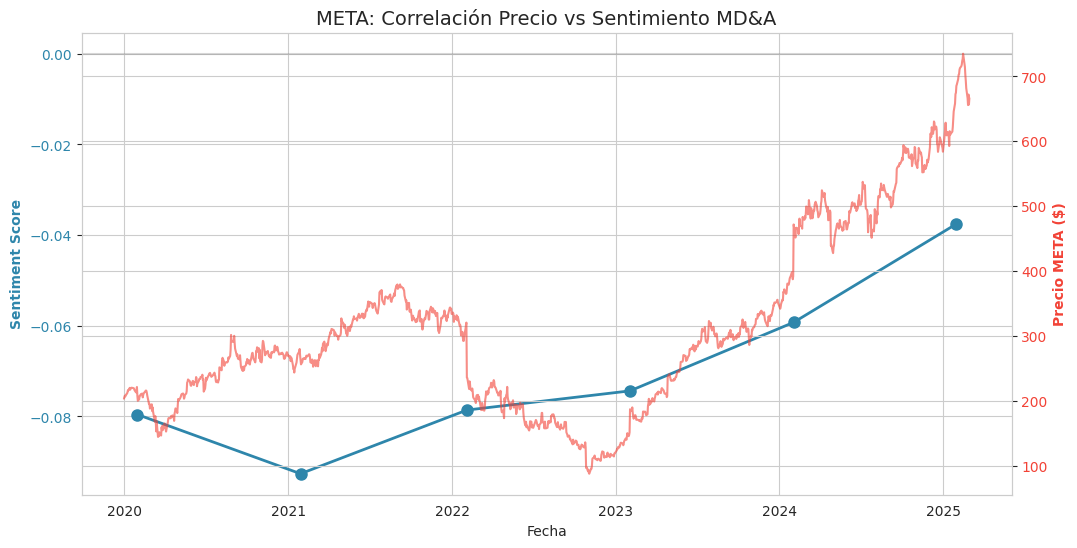



>>> DEEP DIVE (Reporte 2025-01-30)

[TOP 5 POSITIVAS]
(+) 0.82: The timing and results of such user surveys have in the past contributed, and may in the future contribute, to changes in our reported Family metrics ...
(+) 0.76: We are also making significant investments in our metaverse and wearables efforts....
(+) 0.57: To drive greater adoption and acceptance of VR we have introduced MR capabilities, which allow users to experience the immersion and presence of VR wh...
(+) 0.48: We expect this will be a complex, evolving, and long-term initiative....
(+) 0.47: Meta is moving our offerings beyond 2D screens toward immersive experiences like augmented, mixed, and virtual reality to help build the next computin...

[TOP 5 NEGATIVAS]
(-) 0.95: In addition, our data limitations may affect our understanding of certain details of our business and increase the risk of error for our Family metric...
(-) 0.86: We estimate the potential error in our Family metrics primarily based on user su

In [14]:
# @title 3. EJECUCIÓN MAESTRA
TICKER = "META" # @param {type:"string"}
NUM_REPORTS = 6 # @param {type:"integer"}

# 1. Ingesta
loader = SECLoader()
loader.download_filings(TICKER, NUM_REPORTS)
raw_docs = loader.process_filings(TICKER)

if not raw_docs:
    print("[!] No se encontraron datos para procesar.")
else:
    # 2. Análisis
    model = FinBertModel()
    prep = TextPreprocessor()

    all_results = []

    for doc in raw_docs:
        print(f"Processing report from {doc.get('date', 'Unknown Date')}...")
        sentences = prep.split_sentences(prep.clean_text(doc['text']))

        df_sent = model.predict(sentences)
        if not df_sent.empty:
            df_sent['date'] = doc.get('date', '2023-01-01') # Fallback date
            all_results.append(df_sent)

    # 3. Dashboard
    if all_results:
        final_df = pd.concat(all_results)

        # Obtener Market Data
        dates = pd.to_datetime(final_df['date']).sort_values()
        if not dates.empty:
            start = dates.min() - timedelta(days=30)
            end = dates.max() + timedelta(days=30)
            prices = get_market_data(TICKER, start, end)

            show_dashboard(TICKER, final_df, prices)
        else:
            show_dashboard(TICKER, final_df)